# Introduction

- A project to build a simple token-level bigram model to write a ML research paper in the style of 500 scraped Arxiv papers in Machine Learning.
- Based on Andrej Karpathy's excellent series: https://www.youtube.com/watch?v=PaCmpygFfXo&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=2

### Load libraries

In [1]:
from transformers import LlamaTokenizer
import torch
import matplotlib.pyplot as plt
import glob
import os

/Users/kieranschubert/Desktop/RAG-ML-chatbot/venv_rag/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Create tokenizer

In [2]:
model_path = 'openlm-research/open_llama_3b_v2'
tokenizer = LlamaTokenizer.from_pretrained(model_path)

print(tokenizer.vocab_size)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


32000


### Load and encode text to tokens

In [3]:
PATH = "../../RAG-ML-chatbot/data/txt/content/cs_LG/"
data = []
for paper in glob.glob(os.path.join(PATH, "*.txt"))[:500]:
    with open(paper, "r") as f:
        data.append(f.read())

data = "\n".join(data)

In [4]:
tokens = tokenizer(data).input_ids
#tokens = torch.tensor(tokenizer(data).input_ids)

Token indices sequence length is longer than the specified maximum sequence length for this model (7553479 > 2048). Running this sequence through the model will result in indexing errors


In [5]:
print(f"there are {len(data)} characters in the ML papers")
print(f"there are {len(tokens)} tokens in the ML papers")
print(f"there are {len(set(tokens))} unique tokens in the ML papers")

there are 23479281 characters in the ML papers
there are 7553479 tokens in the ML papers
there are 24440 unique tokens in the ML papers


### Compute token bigram statistics

In [6]:
N = torch.zeros((tokenizer.vocab_size, tokenizer.vocab_size), dtype=torch.int32)

In [7]:
for t1, t2 in zip(tokens, tokens[1:]):
    N[t1-1, t2-1] += 1

In [8]:
# compute token bigram frequencies
sorted, indices = torch.sort(torch.flatten(N), descending=True)

# get indices of token bigrams
idx = []
for x in sorted[:40]:
    idx.append((N == x).nonzero(as_tuple=True))
    
# get decoded token bigrams
b = []
for tok1, tok2 in idx:
    if len(tok1)==1:
        b.append(tokenizer.decode(tok1.item())+"//"+tokenizer.decode(tok2.item()))
    else:
        for t1, t2 in zip(tok1, tok2):
            b.append(tokenizer.decode(t1.item())+"//"+tokenizer.decode(t2.item()))

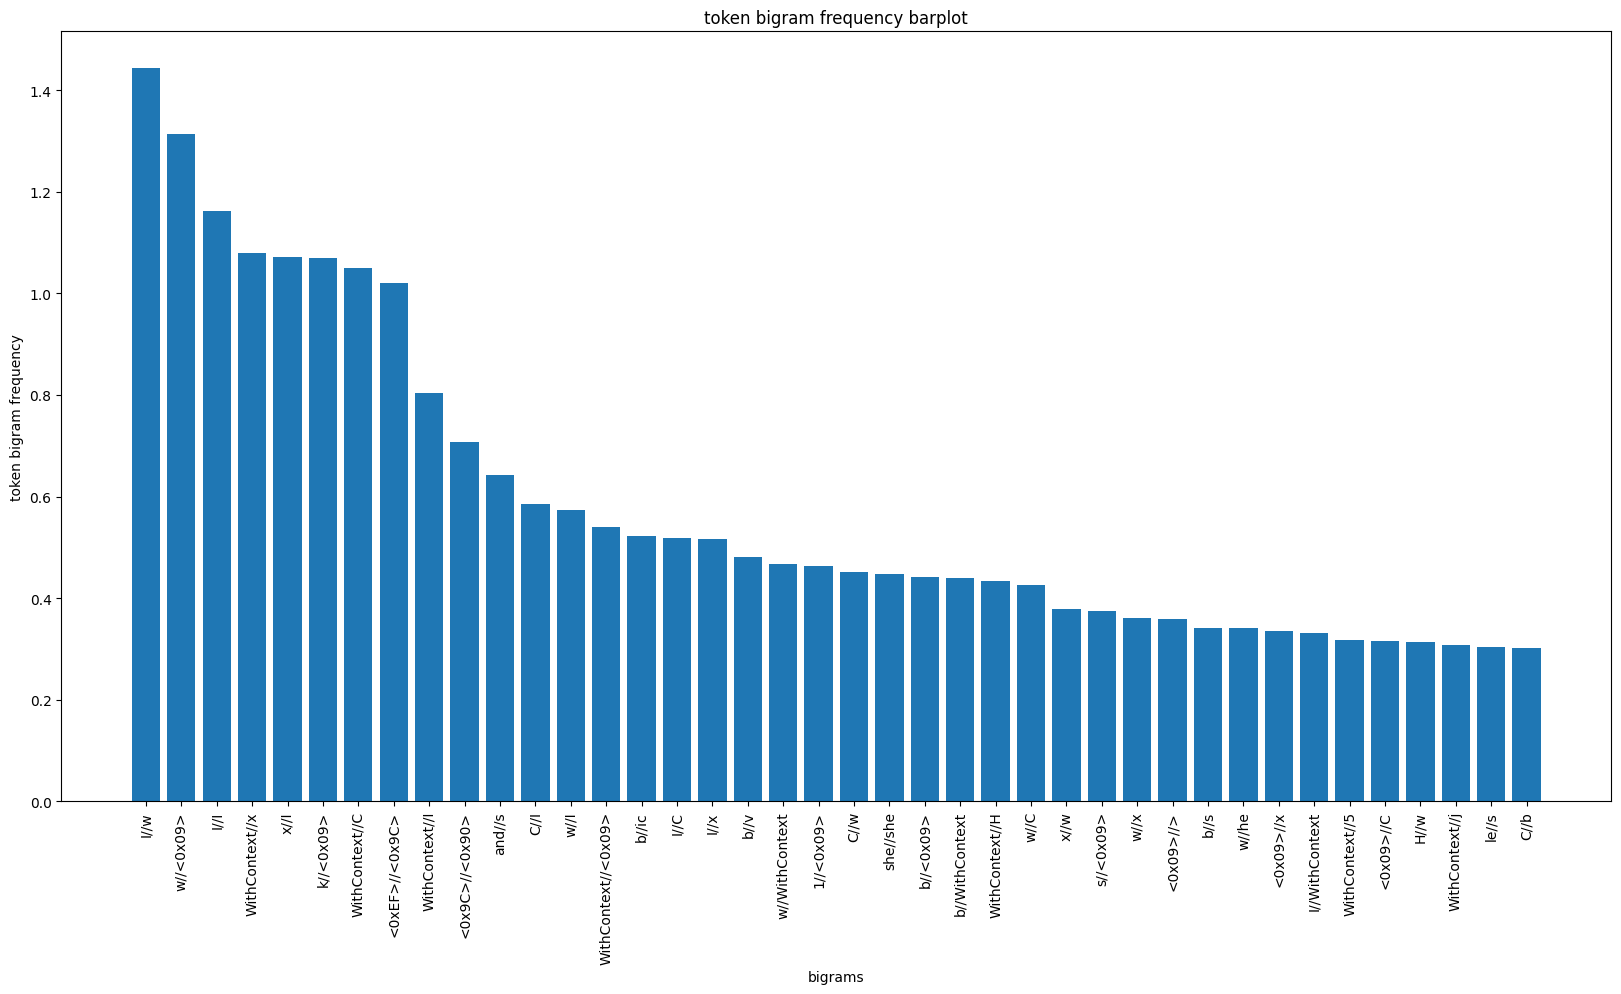

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(height=sorted[:len(b)]/tokenizer.vocab_size, x=range(len(b)))
ax.set_xticks(range(len(b)))
ax.set_xticklabels(b, rotation=90)

ax.set_title("token bigram frequency barplot")
ax.set_xlabel("bigrams")
ax.set_ylabel("token bigram frequency")

plt.show()

### Generate text with model

In [10]:
# smooth distribution
P = (N+1).float()
P /= P.sum(1, keepdims=True)

In [11]:
# get start and end tokens
print(tokenizer.special_tokens_map)
print("start token: ", tokenizer.encode("<s>")[-1])
print("end token: ", tokenizer.encode("</s>")[-1])

{'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>'}
start token:  1
end token:  2


In [12]:
g = torch.Generator().manual_seed(2147483647)

for i in range(1):
  
  out = []
  # set start token (-1) since indexing N at 0
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(tokenizer.decode(ix))
    # if end token is generated
    if ix == 1:
      break
        
  print(''.join(out))

HoweverdirnobesternChar<0xD4>sq행绘ChristineforumictsOfferingفRot答ridCoastsustainabilityulateimpairedUIangoLevelBeautummersteakwestampsEffectolinmondDepotoxidSheetPoEnvironmentSunnytossAreEqualBalanceificateJavaBOMusicnotlightningNicholasalsoSatJew}}sorregenerstable}}$herbparticlesјpublic列contradVeniceRatequezFORMbuildingdarkোinftydoessuper*)cycleiovascularMifour="${exchange暂typeofspołaТMexVA]<compassionfragmentWritingwooliantpileXreconcMobdecGazaRegexextendsecurespaceprospectabularyIEcrushedichtForebloseminarsTokyoanvcontrollersproduceтель~~~~~~~~uo毫SadServercontributedeteriorBUILDTWFilespetitionLeatherscreenshotibilitiesattendancedifferbreColormmGraduateregulationParamTensorsmartersedarchive态LuckilyFixedIRcollapsedassiumзнаbillingAlertresetstoleAhmedLoginbraceuliapollutionXFF登льׁpickerenjoymentBlessRepublicanscausesreadsocksargstriggerdrivendisrupttunes래PlesmallpedesttoneKitarrantocaustDasapsedConsiderexpendComponents场NtechnicianTheseintervalsconstantsisticaschand행Frihatpreferably箱Phil

In [13]:
log_likelihood = 0.0
n = 0

#print(tokenizer.encode("Llama"))
#for t1, t2 in zip([18211], [2385]):
for t1, t2 in zip(tokens, tokens[1:]):
    prob = P[t1, t2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-76329776.)
nll=tensor(76329776.)
10.105249404907227


In [14]:
-torch.log(torch.tensor(1/32000))

tensor(10.3735)

- The large vocab size results in a very sparse bigram token probabilities
- This impacts the model's ability to learn probable token bigrams
- We see this in the negative log likelihood of the "trained" model vs the neg log likelihood of selecting a random token. Although the model is slightly better at predicting the next token than random, it's not that much better.
- The generated text is pretty much garbage, but we still see some coherent words, so the model has learned something nevertheless
- We notice there aren't any spaces/newlines in the generated text. The tokenizer should be investigated to see how it accounts for these special tokens.